#Sarcasm Analysis model development v0.2
###For TrendSentimentAnalysis (tsa.)
Joyster Rodrigues | 2018487

#Importing Dependencies & Datasets, etc.

In [ ]:
#imports
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dropout, Dense

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2023-04-02 11:53:16--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2023-04-02 11:53:16 (54.7 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



##Pre-processing dataset

In [ ]:
df_dataset = pd.read_json('/tmp/sarcasm.json')

In [ ]:
df_backup = df_dataset.copy()

In [ ]:
df_dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df_dataset.describe(include='all')

,article_link,headline,is_sarcastic
count,26709,26709,26709.000000
unique,26708,26602,NaN
top,https://www.huffingtonpost.comhttp://nymag.com...,sunday roundup,NaN
freq,2,10,NaN
mean,NaN,NaN,0.438953
std,NaN,NaN,0.496269
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


In [ ]:
df_dataset = df_dataset.drop(columns='article_link')

In [ ]:
df_dataset.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df_dataset.describe(include='all')

,headline,is_sarcastic
count,26709,26709.000000
unique,26602,NaN
top,sunday roundup,NaN
freq,10,NaN
mean,NaN,0.438953
std,NaN,0.496269
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [ ]:
df_dataset = df_dataset.drop_duplicates()

In [ ]:
df_dataset.describe(include='all')

,headline,is_sarcastic
count,26602,26602.000000
unique,26602,NaN
top,former versace store clerk sues over secret 'b...,NaN
freq,1,NaN
mean,NaN,0.437975
std,NaN,0.496147
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [ ]:
x_sentences = []
y_labels = []

x_sentences = df_dataset['headline'].copy()
y_labels = df_dataset['is_sarcastic'].copy()

In [ ]:
print(f'{len(x_sentences)} | {len(y_labels)}')

26602 | 26602


In [ ]:
# split sarcasm dataset to train & test
split_ratio = round(len(df_dataset) * 0.80)

x_train = x_sentences[0:split_ratio]
x_test = x_sentences[split_ratio:]
y_train = y_labels[0:split_ratio]
y_test = y_labels[split_ratio:]

In [ ]:
# tokenization & padding (sarc)
tokenizer = Tokenizer(num_words=10000, oov_token='<00V>', lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
print(word_index)

{'<00V>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'from': 15, 'at': 16, 'about': 17, 'you': 18, 'by': 19, 'after': 20, 'this': 21, 'up': 22, 'out': 23, 'be': 24, 'how': 25, 'that': 26, 'it': 27, 'as': 28, 'not': 29, 'are': 30, 'your': 31, 'what': 32, 'his': 33, 'all': 34, 'he': 35, 'who': 36, 'just': 37, 'has': 38, 'will': 39, 'more': 40, 'into': 41, 'one': 42, 'year': 43, 'report': 44, 'have': 45, 'over': 46, 'why': 47, 'area': 48, 'donald': 49, 'u': 50, 'day': 51, 'can': 52, 'says': 53, 's': 54, 'first': 55, 'woman': 56, 'time': 57, 'like': 58, 'get': 59, 'her': 60, 'old': 61, "trump's": 62, 'no': 63, 'now': 64, 'an': 65, 'off': 66, 'life': 67, 'obama': 68, 'people': 69, 'than': 70, 'house': 71, 'back': 72, 'was': 73, 'still': 74, "'": 75, 'white': 76, 'women': 77, 'make': 78, 'down': 79, 'clinton': 80, 'my': 81, 'when': 82, 'if': 83, '5': 84, 'i': 85, 'americans': 86, 'world': 87, 'could': 

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=200, padding='post', truncating='post')

x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=200, padding='post', truncating='post')

In [ ]:
print(x_test_pad)

[[ 238 7134  539 ...    0    0    0]
 [   1 6486    1 ...    0    0    0]
 [ 227  852  952 ...    0    0    0]
 ...
 [   1    9   68 ...    0    0    0]
 [1508  389 4299 ...    0    0    0]
 [   1 1801    6 ...    0    0    0]]


In [ ]:
type(x_test_pad)

numpy.ndarray

In [ ]:
#converting py array to np array
x_train_pad = np.array(x_train_pad)
y_train = np.array(y_train)
x_test_pad = np.array(x_test_pad)
y_test = np.array(y_test)

#Model Architecture v0.2

## model 1

In [ ]:
# model architecture 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=150),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model1 = Sequential()
model1.add(Embedding(input_dim=10000, output_dim=16, input_length=200))
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(rate=0.20))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
________________________________________________

In [ ]:
#fit model
epoch_runs = 5

hist = model1.fit(x_train_pad, y_train, epochs=epoch_runs, validation_data=(x_test_pad, y_test), verbose=2)

Epoch 1/5
666/666 - 9s - loss: 0.6836 - accuracy: 0.5578 - val_loss: 0.6700 - val_accuracy: 0.5699 - 9s/epoch - 13ms/step
Epoch 2/5
666/666 - 4s - loss: 0.5705 - accuracy: 0.7032 - val_loss: 0.4443 - val_accuracy: 0.8273 - 4s/epoch - 6ms/step
Epoch 3/5
666/666 - 4s - loss: 0.3764 - accuracy: 0.8497 - val_loss: 0.3748 - val_accuracy: 0.8445 - 4s/epoch - 6ms/step
Epoch 4/5
666/666 - 5s - loss: 0.3116 - accuracy: 0.8736 - val_loss: 0.3605 - val_accuracy: 0.8462 - 5s/epoch - 7ms/step
Epoch 5/5
666/666 - 3s - loss: 0.2733 - accuracy: 0.8922 - val_loss: 0.3586 - val_accuracy: 0.8436 - 3s/epoch - 5ms/step


In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model2.add(Dropout(rate=0.20))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(rate=0.20))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout_2 (Dropout)         (None, 200, 128)          0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model2.fit(x_train_pad, y_train, validation_data=(x_test_pad, y_test), epochs=50, batch_size=64, callbacks=[es, mc])

Epoch 1/50
332/333 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.5729
Epoch 1: val_accuracy improved from -inf to 0.68045, saving model to best_model.h5
333/333 [==============================] - 20s 54ms/step - loss: 0.6720 - accuracy: 0.5731 - val_loss: 0.5956 - val_accuracy: 0.6805
Epoch 2/50
332/333 [============================>.] - ETA: 0s - loss: 0.4469 - accuracy: 0.8078
Epoch 2: val_accuracy improved from 0.68045 to 0.83947, saving model to best_model.h5
333/333 [==============================] - 17s 51ms/step - loss: 0.4469 - accuracy: 0.8079 - val_loss: 0.3801 - val_accuracy: 0.8395
Epoch 3/50
332/333 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.8697
Epoch 3: val_accuracy improved from 0.83947 to 0.85038, saving model to best_model.h5
333/333 [==============================] - 18s 53ms/step - loss: 0.3181 - accuracy: 0.8697 - val_loss: 0.3582 - val_accuracy: 0.8504
Epoch 4/50
332/333 [============================>.] - ETA:

## model 2

In [ ]:
# model2
# model architecture 
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=150),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
model2.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), verbose=2)

#Model evaluation

In [ ]:
# accuracy & loss 

def create_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()


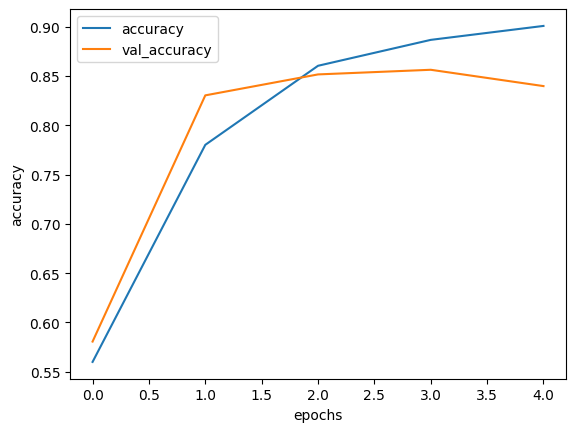

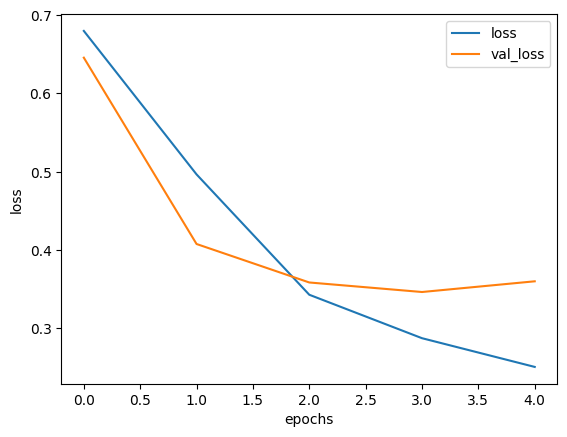

In [ ]:
create_graphs(hist, 'accuracy')
create_graphs(hist, 'loss')

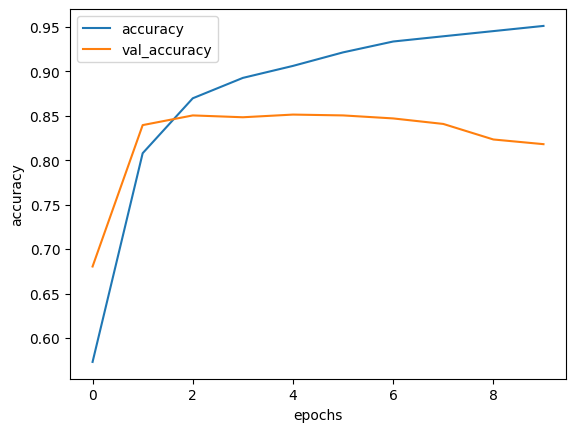

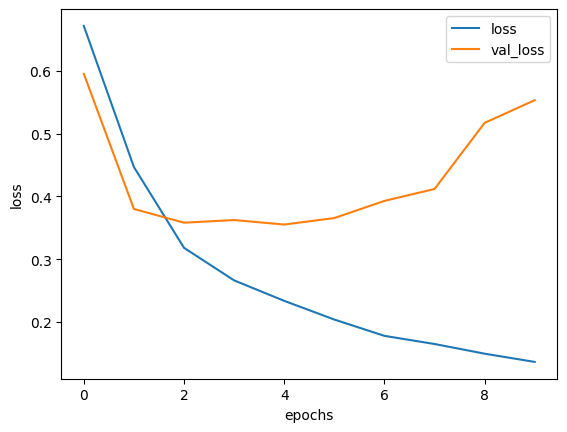

In [ ]:
create_graphs(history, 'accuracy')
create_graphs(history, 'loss')

In [ ]:

def conf_matrix(model):
  y_true = y_test
  y_pred = model.predict(x_test_pad)
  y_pred = np.where(np.round(y_pred)>0.5,1,0)


  conf_matrix = confusion_matrix(y_true, y_pred)

  # confusion matrix
  print(conf_matrix)

  sns.heatmap(conf_matrix, cmap='YlGn', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

167/167 [==============================] - 2s 7ms/step
[[2777  255]
 [ 598 1690]]


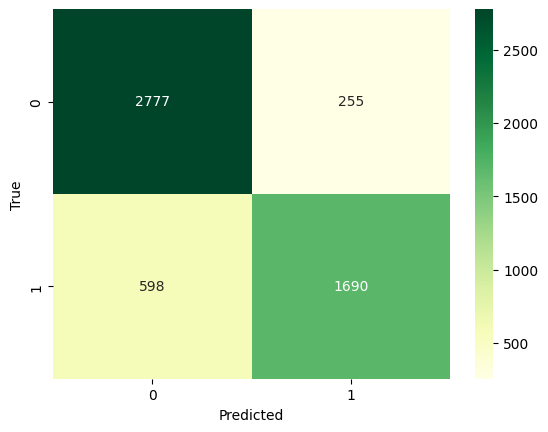

In [ ]:
conf_matrix(model1)

167/167 [==============================] - 1s 6ms/step
[[2593  439]
 [ 352 1936]]


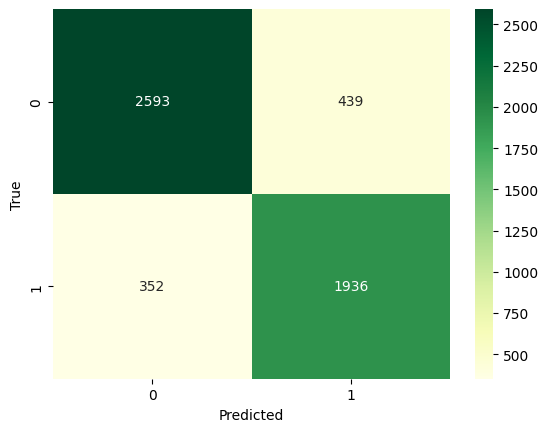

In [ ]:
final_model = keras.models.load_model('/content/best_model.h5')
conf_matrix(final_model)

In [ ]:
def class_report(model):
    y_true = y_test
    y_pred = model.predict(x_test_pad)
    y_pred = np.where(np.round(y_pred)>0.5,1,0)

    print(classification_report(y_test, y_pred))

In [ ]:
class_report(model1)

167/167 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3032
           1       0.87      0.74      0.80      2288

    accuracy                           0.84      5320
   macro avg       0.85      0.83      0.83      5320
weighted avg       0.84      0.84      0.84      5320



In [ ]:
class_report(final_model)

167/167 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3032
           1       0.82      0.85      0.83      2288

    accuracy                           0.85      5320
   macro avg       0.85      0.85      0.85      5320
weighted avg       0.85      0.85      0.85      5320



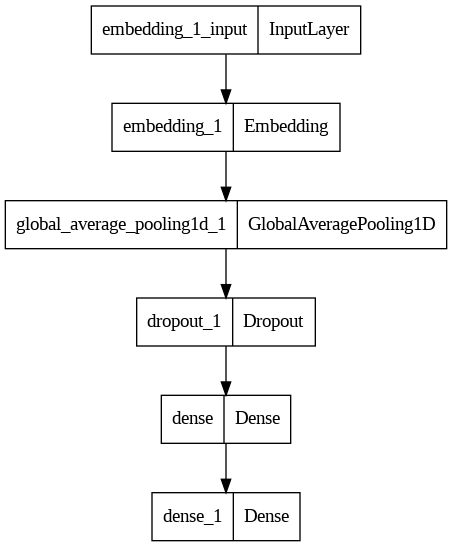

In [ ]:
tf.keras.utils.plot_model(
    model1,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

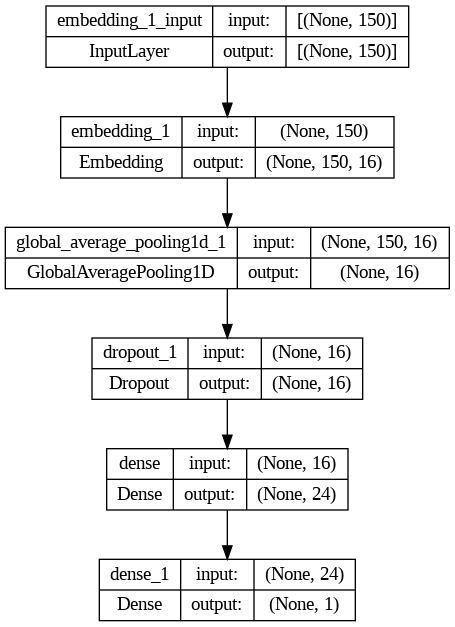

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [ ]:
tf.keras.models.save_model(model1, '/content/models')

#Testing model

In [ ]:
test_sentences = ['today has been a rough week']
test_seq = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=150, padding='post', truncating='post')

test_output = model.predict(test_padded)

In [ ]:
def sarc_classification(input):
  if input >= 0.5:
    return 'sarcasm detected'
  else: 
    return 'sarcasm may not be implied'

In [ ]:
print(sarc_classification(test_output))

In [ ]:
print(test_output)

In [ ]:
test_output2 = model2.predict(test_padded)
print(sarc_classification(test_output2))

#tsa. developement / integration


## save models

In [ ]:
model1.save('sarc_model1')
model1.save('sarc_model1.h5')

In [ ]:
model2.save('sarc_model2')
model2.save('sarc_model2.h5')

In [ ]:
from google.colab import files
!cp -r '/content/sarc_model1' "/content/drive/MyDrive/finalest"
!cp -r '/content/sarc_model1.h5' "/content/drive/MyDrive/finalest"
!cp -r '/content/sarc_model2' "/content/drive/MyDrive/finalest"
!cp -r '/content/sarc_model2.h5' "/content/drive/MyDrive/finalest"

## exporting tokenizer

In [ ]:
import pickle
with open('tokenzier.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp -r '/content/tokenzier.pickle' "/content/drive/MyDrive/finalest"

In [ ]:
tokenizer.save()

#Generating graphs for tsa.

##bar chart

In [ ]:
sarc_or_not = ['sarc', 'not-sarc']
scores = [pos,neg]
fig = plt.figure()
bar = fig.add_axes([0,0,1,1])
colors = ['green', 'red']
bar.bar(sents, scores, color=colors)
plt.title('iOS 16.3.1 tsa results')
plt.xlabel('sentiments')
plt.ylabel('score')
plt.show()

##pie chart

In [ ]:
pie_labels = ['positive', 'negative']
pie = plt.pie(scores, labels=pie_labels)
plt.title('iOS 16.3.1 tsa results')
plt.show()

# Citation:
1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using News Headlines Dataset." AI Open (2023).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).